<a href="https://colab.research.google.com/github/bholeneha/Text_Classification/blob/neha/S3_NaiveBayes_TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
# Importing Spark 
import os
spark_version = 'spark-3.1.1'
os.environ['SPARK_VERSION']=spark_version
 
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark
 
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"
 
# Start a SparkSession
import findspark
findspark.init()
 
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NB").getOrCreate()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [3]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://nehabhole-bucket.s3.us-east-2.amazonaws.com/emails.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("emails.csv"), header=True)

In [4]:
# Check data
df.show()

+---------+--------------------+-----+
|file_name|                text|class|
+---------+--------------------+-----+
|14147.txt| Archive name  ri...|Crime|
|14831.txt|Approved  news an...|Crime|
|14832.txt|Approved  news an...|Crime|
|14982.txt|Message ID   1ppv...|Crime|
|14983.txt|    Some sick par...|Crime|
|14984.txt| There are many U...|Crime|
|14985.txt|  From  res colne...|Crime|
|14986.txt|Message ID   WARL...|Crime|
|14987.txt| neuhaus vier inf...|Crime|
|14988.txt|   This thread br...|Crime|
|14989.txt| With regard to y...|Crime|
|14990.txt| In article  2bb2...|Crime|
|14991.txt|Message ID   1pqu...|Crime|
|14992.txt| In article  1ppg...|Crime|
|14993.txt| strnlght netcom ...|Crime|
|14994.txt| Markowitz DOCKMA...|Crime|
|14995.txt| cuffell spot Col...|Crime|
|14996.txt|   This actually ...|Crime|
|14997.txt| Michael Levin wr...|Crime|
|14998.txt|   cme ellisun sw...|Crime|
+---------+--------------------+-----+
only showing top 20 rows



In [5]:
# Import Pandas and transform dataset to a pandas dataframe
import pandas as pd
data_df = df.toPandas()

In [6]:
# Check the shape of data to check for missing rows
data_df.shape

(9154, 3)

In [7]:
# Check for null values and datatypes
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9154 entries, 0 to 9153
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  9154 non-null   object
 1   text       9123 non-null   object
 2   class      9154 non-null   object
dtypes: object(3)
memory usage: 214.7+ KB


In [8]:
# Check the columns
data_df.columns

Index(['file_name', 'text', 'class'], dtype='object')

In [9]:
# Drop rows with null values
data_df.dropna()

,file_name,text,class
0,14147.txt,Archive name ripem faq Last update Sun 7 M...,Crime
1,14831.txt,Approved news answers request MIT EDU Content...,Crime
2,14832.txt,Approved news answers request MIT EDU Content...,Crime
3,14982.txt,Message ID 1ppvai l79 bilbo suite com Reply...,Crime
4,14983.txt,Some sick part of me really liked that phr...,Crime
...,...,...,...
9149,62615.txt,Distribution world Message ID cshotton 1805...,Science
9150,62616.txt,Jeffrey L Cook sez This object would not ...,Science
9151,62708.txt,Message ID 1tdqmvINN3q2 hp col col hp com R...,Science
9152,62709.txt,Message ID 1t6dd1 11v network ucsd edu Refe...,Science


In [10]:
# Change datatype of the text column to string
data_df['text'] = data_df['text'].astype(str)

In [11]:
#Import dependencies for NLP
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import regex
#from wordcloud import WordCloud
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
# Process the text using NLP methods 
wordnet_lemmatizer = WordNetLemmatizer()

stop = stopwords.words('english')

for punct in punctuation:
    stop.append(punct)
    
# Create a function to filter text
def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha() and len(w) > 3]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words] 
    return " ".join(filtered_text)

In [13]:
# Create a filtered_text column and add filtered text data
data_df["filtered_text"] = data_df.text.apply(lambda x : filter_text(x, stop)) 
data_df

,file_name,text,class,filtered_text
0,14147.txt,Archive name ripem faq Last update Sun 7 M...,Crime,archive name ripem last update post still rath...
1,14831.txt,Approved news answers request MIT EDU Content...,Crime,approve news answer request content type text ...
2,14832.txt,Approved news answers request MIT EDU Content...,Crime,approve news answer request content type text ...
3,14982.txt,Message ID 1ppvai l79 bilbo suite com Reply...,Crime,message bilbo suite reply miller suite nntp po...
4,14983.txt,Some sick part of me really liked that phr...,Crime,sick part really like phrase actually merely t...
...,...,...,...,...
9149,62615.txt,Distribution world Message ID cshotton 1805...,Science,distribution world message cshotton reference ...
9150,62616.txt,Jeffrey L Cook sez This object would not ...,Science,jeffrey cook object would interfere anyone enj...
9151,62708.txt,Message ID 1tdqmvINN3q2 hp col col hp com R...,Science,message reference jut amdahl nntp post host hp...
9152,62709.txt,Message ID 1t6dd1 11v network ucsd edu Refe...,Science,message network ucsd reference ucsu colorado n...


In [14]:
# Loop over filtered text in each row and create a word list
word_list = []
for text in data_df["filtered_text"]:
    temp = text.split(" ")
    word_list.append(temp)
 
# Print the word list    
word_list[0:2]

[['archive',
  'name',
  'ripem',
  'last',
  'update',
  'post',
  'still',
  'rather',
  'rough',
  'list',
  'likely',
  'question',
  'information',
  'ripem',
  'program',
  'public',
  'mail',
  'encryption',
  'ripem',
  'write',
  'maintain',
  'marc',
  'vanheyningen',
  'mvanheyn',
  'whale',
  'indiana',
  'post',
  'variety',
  'newsgroups',
  'monthly',
  'basis',
  'follow',
  'discussion',
  'specific',
  'ripem',
  'redirect',
  'group',
  'security',
  'ripem',
  'month',
  'reformatted',
  'post',
  'attempt',
  'comply',
  'standards',
  'hypertext',
  'format',
  'allow',
  'easy',
  'manipulation',
  'document',
  'world',
  'wide',
  'know',
  'think',
  'disclaimer',
  'nothing',
  'consider',
  'legal',
  'advice',
  'anything',
  'person',
  'opinion',
  'want',
  'real',
  'legal',
  'advice',
  'talk',
  'real',
  'lawyer',
  'question',
  'answer',
  'ripem',
  'ripem',
  'program',
  'perform',
  'privacy',
  'enhance',
  'mail',
  'use',
  'cryptographic',

In [15]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.corpora as corpora

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
data_df['class_id'] = data_df['class'].factorize()[0]
class_id_df = data_df[['class', 'class_id']].drop_duplicates().sort_values('class_id')
class_to_id = dict(class_id_df.values)
id_to_class = dict(class_id_df[['class_id', 'class']].values)

In [17]:
data_df.class_id.unique()

array([0, 1, 2, 3])

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data_df.filtered_text).toarray()

features.shape

(9154, 56248)

In [19]:
labels = data_df["class"]

"We can use feature_selection.chi2 to find the terms that are the most correlated with each of the [classes]."

In [20]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Class, class_id in sorted(class_to_id.items()):
  features_chi2 = chi2(features, labels == class_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Class))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Crime':
  . Most correlated unigrams:
. foresee
. foresight
  . Most correlated bigrams:
. foreign office
. zurich nntp
# 'Entertainment':
  . Most correlated unigrams:
. foresee
. foresight
  . Most correlated bigrams:
. foreign office
. zurich nntp
# 'Politics':
  . Most correlated unigrams:
. foresee
. foresight
  . Most correlated bigrams:
. foreign office
. zurich nntp
# 'Science':
  . Most correlated unigrams:
. foresee
. foresight
  . Most correlated bigrams:
. foreign office
. zurich nntp


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


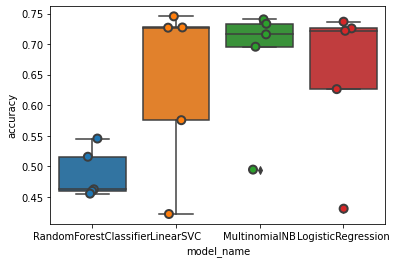

In [22]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [23]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.639511
LogisticRegression        0.648358
MultinomialNB             0.676104
RandomForestClassifier    0.487877
Name: accuracy, dtype: float64

### SVC / LOGISTIC REGRESSION / NAIVE BAYES SEEM TO WORK BEST

## NB WORKS SUPER BEST

## Naive Bayes (Apparently the best for this dataset)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


X_train, X_test, y_train, y_test = train_test_split(data_df["filtered_text"], data_df['class'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [27]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Politics']


In [28]:
print(clf.predict(count_vect.transform(["A chair is a piece of furniture with a raised surface used to sit on, commonly for use by one person. Chairs are most often supported by four legs and have a back;[1][2] however, a chair can have three legs or could have a different shape.[3] A chair without a back or arm rests is a stool,[4] or when raised up, a bar stool.[5] A chair with arms is an armchair[6] and with folding action and inclining footrest, a recliner.[7] A permanently fixed chair in a train or theater is a seat[8] or, in an airplane, airline seat;[9] when riding, it is a saddle[10] and bicycle saddle,[11] and for an automobile, a car seat[12] or infant car seat.[13] With wheels it is a wheelchair[14] and when hung from above, a swing.[15] A chair for more than one person is a couch, sofa, settee, or loveseat;[16] or a bench.[17] A separate footrest for a chair is known as an ottoman,[18] hassock[19] or pouffe.[20]The chair is known for its antiquity and simplicity, although for many centuries it was an article of state and dignity rather than an article of ordinary use. The chair is still extensively used as the emblem of authority in the House of Commons in the United Kingdom and Canada, and in many other settings."])))

['Politics']


In [29]:
print(clf.predict(count_vect.transform(["RIPEM is a program which performs Privacy Enhanced Mail (PEM) using the cryptographic techniques of RSA and DES.  It allows your electronic mail to have the properties of authentication (i.e. who sent it can be confirmed) and privacy (i.e. nobody can read it except the intended recipient.) RIPEM was written primarily by Mark Riordan <mrr@scss3.cl.msu.edu>. Most of the code is in the public domain, except for the RSA routines, which are a library called RSAREF licensed from RSA Data Security Inc. RIPEM contains the library of cryptographic routines RSAREF, which is considered munitions and thus is export-restricted from distribution to people who are not citizens or permanent residents of the U.S. or Canada.  Therefore, the following request is quoted from the README file:"])))

['Science']


In [30]:
print(clf.predict(count_vect.transform(["Checking to see what on earth is going on with this thing. Can I possibly get Entertainment? Why is the entertainment no entertaining?"])))

['Science']


In [31]:
# Connect Google Drive to Colab Notebooks
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
import joblib
joblib.dump(clf, "/content/gdrive/MyDrive/NB_Model/NB_Model")

['/content/gdrive/MyDrive/NB_Model/NB_Model']

In [46]:
!ls /content/gdrive/MyDrive/NB_Model

NB_Model
